# Deep Convolutional Generative Adverserial Networks

In [1]:
# to generate gifs
!pip install imageio


    100% |████████████████████████████████| 3.3MB 933kB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio


# Import TensorFlow and enable eager execution

In [0]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display

# Load the dataset

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# We are normalizing the images to the range of [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256


# Use tf.data to create batches and shuffle the dataset

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Write the generator and discriminator models

In [0]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    
    self.fc1 = tf.keras.layers.Dense(7*7*64, use_bias=False)
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
   
    
    self.conv1 = tf.keras.layers.Conv2DTranspose(64, (5, 5),
                                                 strides=(1, 1),
                                                 padding='same',
                                                 use_bias=False)
    self.batchnorm2 = tf.keras.layers.BatchNormalization()
    
    
    self.conv2 = tf.keras.layers.Conv2DTranspose(32, (5, 5),
                                                 strides=(2, 2), 
                                                 padding='same', 
                                                 use_bias=False)
    self.batchnorm3 = tf.keras.layers.BatchNormalization()
    
    
    self.conv3 = tf.keras.layers.Conv2DTranspose(1, (5, 5),
                                                 strides=(2, 2), 
                                                 padding='same', 
                                                 use_bias=False)

    
  def call(self, x, training=True):
    x = self.fc1(x)
    x = self.batchnorm1(x, training=training)
    x = tf.nn.relu(x)

    x = tf.reshape(x, shape=(-1, 7, 7, 64))

    x = self.conv1(x)
    x = self.batchnorm2(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2(x)
    x = self.batchnorm3(x, training=training)
    x = tf.nn.relu(x)

    x = tf.nn.tanh(self.conv3(x))  
    return x

In [0]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    
    self.conv1 = tf.keras.layers.Conv2D(64, (5, 5),
                                        strides=(2, 2),
                                        padding='same')
    
    
    self.conv2 = tf.keras.layers.Conv2D(128, (5, 5),
                                        strides=(2, 2), 
                                        padding='same')
    
    
    self.dropout = tf.keras.layers.Dropout(0.3)
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(1)

  def call(self, x, training=True):
    x = tf.nn.leaky_relu(self.conv1(x))
    x = self.dropout(x, training=training)
    x = tf.nn.leaky_relu(self.conv2(x))
    x = self.dropout(x, training=training)
    x = self.flatten(x)
    x = self.fc1(x)
    return x

In [0]:
generator = Generator()
discriminator = Discriminator()

In [0]:
# Defun gives 10 secs/epoch performance boost
generator.call = tf.contrib.eager.defun(generator.call)
discriminator.call = tf.contrib.eager.defun(discriminator.call)

# Define the loss functions and the optimizer

In [0]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want
    # our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [0]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [0]:
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)
generator_optimizer = tf.train.AdamOptimizer(1e-4)

# Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training

In [0]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
def train(dataset, epochs, noise_dim):  
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      # generating noise from a uniform distribution
      noise = tf.random_normal([BATCH_SIZE, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

      
    if epoch % 1 == 0:
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)


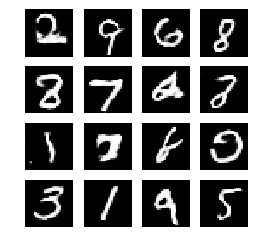

In [56]:
train(train_dataset, EPOCHS, noise_dim)


# Restore the latest checkpoint

In [57]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


# Display an image using the epoch number

In [0]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

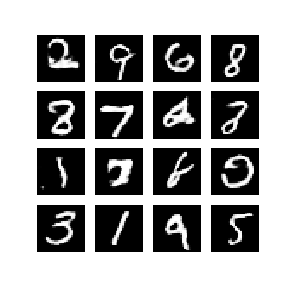

In [59]:
display_image(EPOCHS)


# Generate a GIF of all the saved images.

In [60]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp dcgan.gif dcgan.gif.png')

0

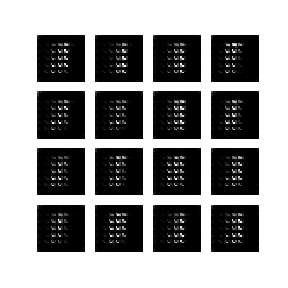

In [61]:
display.Image(filename="dcgan.gif.png")

In [0]:
from google.colab import files
files.download('dcgan.gif')